###Analyse

* Wat is het probleem? 
   - We gaan voorspellen of iemand kleding aanraadt of niet door middel van de tekst die ze achter laten in hun review. 
* Wat voor labels heb je?
  - recommended 
* **Soorten data/features?**
  De data bestaat uit tekst en cijfers.
  **Features**:
    - Clothing ID: Integer Categorical variable that refers to the specific piece being reviewed.
    - Age: Positive Integer variable of the reviewers age.
    - Title: String variable for the title of the review.
    - Review Text: String variable for the review body.
    - Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
    - Recommended IND: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
    - Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.
    - Division Name: Categorical name of the product high level division.
    - Department Name: Categorical name of the product department name.
    - Class Name: Categorical name of the product class name.


###Voorspelling:
* Welke classifier zal het beste zijn en waarom? 
  * De naive bayes. Dit omdat het er om bekend staan om tekst analysis goed te kunnen verwerken.
* Welke hyperparameters zijn relevant en waarom?
  - Voor de Naive Bayes de C parameter.

###Methoden
* Welke preprocessing stappen zijn nodig?
  -  De text opschonen, dus hoofdletters verwijderen, leestekens verwijderen etc
  - De tekst zal omgezet moeten worden naar iets wat de classifier zal begrijpen.
* Welke classifiers ga je vergelijken? (Minimaal 2 per dataset)
  - Logistic regression en naive bayes.
* Welke performance metric is passend?
  - De F1 score, dit omdat het een goede weergave is tussen alle true/false positives en true/false negatives.

###Resultaten

*Niet alleen beste resultaat geven, het gaat juist ook om de vergelijking/verbetering!*
* Minimaal 1 visualisatie/plotje per dataset.
* Evaluatie/conclusie
* Welke classifier leverde beste resultaat op?
* Klopt dit met je voorspelling? Waarom wel/niet?

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.model_selection import train_test_split , cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score,f1_score, classification_report
from mlxtend.plotting import plot_confusion_matrix
import math
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

In [2]:
df = pd.read_csv("/content/drive/MyDrive/minor/ML/Womens Clothing E-Commerce Reviews.csv", sep =",")

In [3]:
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


Hier zien we al enkele NaN-waardes, laten we kijken hoeveel er in totaal in de data zitten:

In [4]:
print(df.isna().sum())

Unnamed: 0                    0
Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64


In 5 kolommen zitten er NaN-waardes. In 'title' en 'review text' ontbreken er veel waardes. In de laatste 3 missen er enkele gegevens. Als we deze kolommen niet nodig hebbben, kunnen we deze gewoon verwijderen.

In [5]:
df['Review Text'].fillna('unknown', inplace=True)

In [6]:
# Make lowercase
df['Review Text'] = df['Review Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Remove whitespaces
df['Review Text'] = df['Review Text'].apply(lambda x: " ".join(x.strip() for x in x.split()))

# Remove special characters
df['Review Text'] = df['Review Text'].apply(lambda x: "".join([" " if ord(i) < 32 or ord(i) > 126 else i for i in x]))

# Remove punctuation
df['Review Text'] = df['Review Text'].str.replace('[^\w\s]', '')

# Remove numbers
df['Review Text'] = df['Review Text'].str.replace('\d+', '')

# # Remove Stopwords
# df['Review Text'] = df['Review Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Convert to string
df['Review Text'] = df['Review Text'].astype(str)
df

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,absolutely wonderful silky and sexy and comfo...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,love this dress its sooo pretty i happened to ...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,i had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,i love love love this jumpsuit its fun flirty ...,5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,this shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...,...
23481,23481,1104,34,Great dress for many occasions,i was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,23482,862,48,Wish it was made of cotton,it reminds me of maternity clothes soft stretc...,3,1,0,General Petite,Tops,Knits
23483,23483,1104,31,"Cute, but see through",this fit well but the top was very see through...,3,0,1,General Petite,Dresses,Dresses
23484,23484,1084,28,"Very cute dress, perfect for summer parties an...",i bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


Hieronder is te zien welke kolommen geen cijfers zijn:

In [7]:
# Namen veranderen
df.rename(columns={'Clothing ID':'clothing_id','Recommended IND':'recommended', 'Review Text':'review_text'},inplace=True)

df = df[['clothing_id', 'recommended', 'review_text']]
df.head()

,clothing_id,recommended,review_text
0,767,1,absolutely wonderful silky and sexy and comfo...
1,1080,1,love this dress its sooo pretty i happened to ...
2,1077,0,i had such high hopes for this dress and reall...
3,1049,1,i love love love this jumpsuit its fun flirty ...
4,847,1,this shirt is very flattering to all due to th...


In [8]:
df.isna().sum()

clothing_id    0
recommended    0
review_text    0
dtype: int64

Alle NaN-values zijn ook echt verwijderd zoals is te zien.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   clothing_id  23486 non-null  int64 
 1   recommended  23486 non-null  int64 
 2   review_text  23486 non-null  object
dtypes: int64(2), object(1)
memory usage: 550.6+ KB


We hebben geen null-values en alle waardes zijn Integers.

In [10]:
X = df.review_text
y = df.recommended

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 43)

print(X.shape)
print(y.shape)

(23486,)
(23486,)


In [11]:
from sklearn.feature_extraction.text import CountVectorizer
cvect = CountVectorizer(encoding='utf-8')
X_train_vect = cvect.fit_transform(X_train)
X_train_vect.shape


X_test_vect = cvect.transform(X_test)
X_test_vect.shape

(4698, 16287)

Controleren of het werkt:

In [12]:
cvect.vocabulary_.get('love')

8048

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
X_train_transformed = transformer.fit_transform(X_train_vect)
X_train_transformed.shape

X_test_transformed = transformer.transform(X_test_vect)
X_test_transformed.shape

(4698, 16287)

Naive Bayes model

In [14]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=0.001)
nb.fit(X_train_transformed, y_train)

nb_pred = nb.predict(X_test_transformed)
nb_acc = accuracy_score(y_test, nb_pred)
print(f1_score(y_test, nb_pred))

0.9161008729388943


In [15]:
# precision tp / (tp + fp)
nb_precision = precision_score(y_test, nb_pred)
print('Precision: %f' % nb_precision)

# recall: tp / (tp + fn)
nb_recall = recall_score(y_test, nb_pred)
print('Recall: %f' % nb_recall)

# f1: 2 tp / (2 tp + fp + fn)
nb_f1 = f1_score(y_test, nb_pred)
print('F1 score: %f' % nb_f1)

Precision: 0.858051
Recall: 0.982575
F1 score: 0.916101


<Figure size 432x288 with 0 Axes>

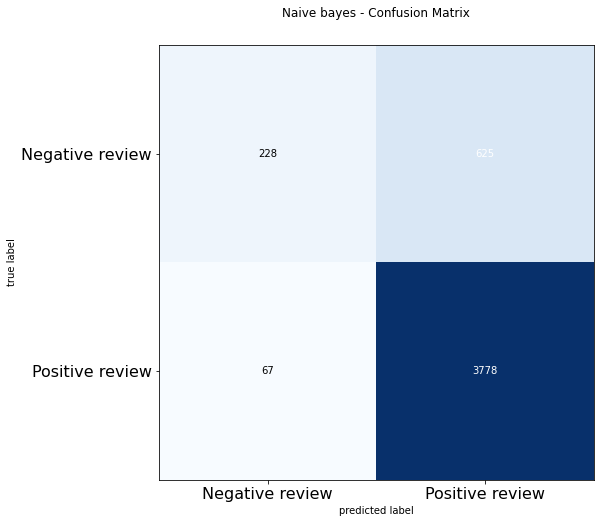

In [16]:
cm = confusion_matrix(y_test, nb_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Naive bayes - Confusion Matrix")
plt.xticks(range(2), ["Negative review","Positive review"], fontsize=16)
plt.yticks(range(2), ["Negative review","Positive review"], fontsize=16)
plt.show()

Logistic regression:

In [17]:
log_reg = LogisticRegression()
log_reg.fit(X_train_transformed, y_train)
logr_pred = log_reg.predict(X_test_transformed)

<Figure size 432x288 with 0 Axes>

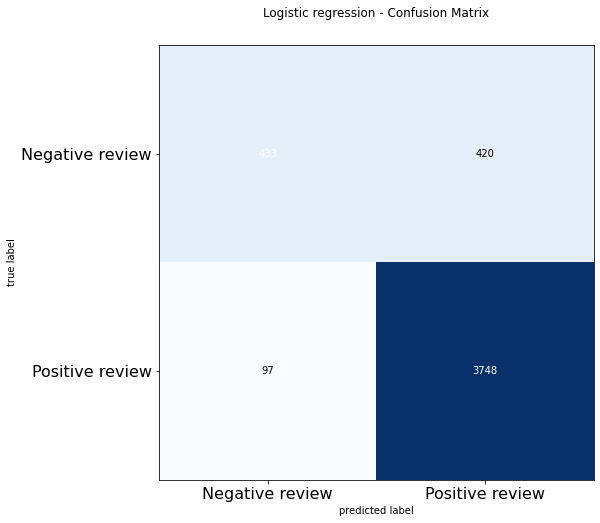

Precision: 0.899232
Recall: 0.974772
F1 score: 0.935480


In [18]:
cm = confusion_matrix(y_test, logr_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Logistic regression - Confusion Matrix")
plt.xticks(range(2), ["Negative review","Positive review"], fontsize=16)
plt.yticks(range(2), ["Negative review","Positive review"], fontsize=16)
plt.show()

# precision tp / (tp + fp)
logr_precision = precision_score(y_test, logr_pred)
print('Precision: %f' % logr_precision)

# recall: tp / (tp + fn)
logr_recall = recall_score(y_test, logr_pred)
print('Recall: %f' % logr_recall)

# f1: 2 tp / (2 tp + fp + fn)
logr_f1 = f1_score(y_test, logr_pred)
print('F1 score: %f' % logr_f1)

#Conclusie

In [19]:
#Conclusie
print(f'F1 score logistic regression: %{logr_f1}')
print(f'F1 score Naive Bayes: %{nb_f1}')

F1 score logistic regression: %0.9354798452514663
F1 score Naive Bayes: %0.9161008729388943


Uit bovenstaande resultaten is te zien dat de Logistic regression het het beste gedaan heeft en de Naive Bayes het slechtst. Ik had voorspeld dat de Naive Bayes classifier het beste resultaat zou geven. Dit komt dus niet overeen. Dit komt waarschijnljk omdat de NAive bayes alle features onafhankelijk van elkaar zijn, terwijl dit vaak niet zo is.

#Bronnen

- https://www.kaggle.com/vipulgandhi/how-to-choose-right-metric-for-evaluating-ml-model#data
- 
